In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer


In [2]:
path ="airbnb_listings.csv"

df = pd.read_csv(path)
df.head(1)

,id,listing_url,name,summary,space,description,neighborhood_overview,notes,transit,access,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,33159143,https://www.airbnb.com/rooms/33159143,"PRIVATE ROOM, SAFE NEIGHBORHOOD IN SCRIPPS RANCH",80% of the house + yourCozy room ... in Scripp...,"Full bed, private bath...",80% of the house + yourCozy room ... in Scripp...,The neighborhood is a typical Southern Califor...,Have alarm system if you choose to use... I wi...,You can park in the drive way or plenty of spa...,"Kitchen, Dining room, Living room, Very Comfor...",...,NaN,NaN,NaN,NaN,f,t,f,strict_14_with_grace_period,f,f


In [3]:
df.columns

Index(['id', 'listing_url', 'name', 'summary', 'space', 'description',
       'neighborhood_overview', 'notes', 'transit', 'access', 'interaction',
       'house_rules', 'thumbnail_url', 'host_id', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'street', 'neighbourhood',
       'neighbourhood_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet',
       'nightly_price', 'price_per_stay', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',

# Exploratory Data Analysis (EDA)

### Distribution of Nightly Price & Log Transformation
The distribution of nightly listing prices is heavily right-skewed, with most properties priced under 500 dollars but a long tail extending beyond $10,000. Such skewness can negatively impact model stability due to the disproportionate influence of high-value listings. To mitigate this, we apply a log transformation using log(price+1), which generates a more compact and approximately symmetric distribution. This transformation stabilizes variance and improves regression model performance by emphasizing proportional, rather than absolute, price differences. The contrast between raw and log-transformed price distributions clearly supports this decision.

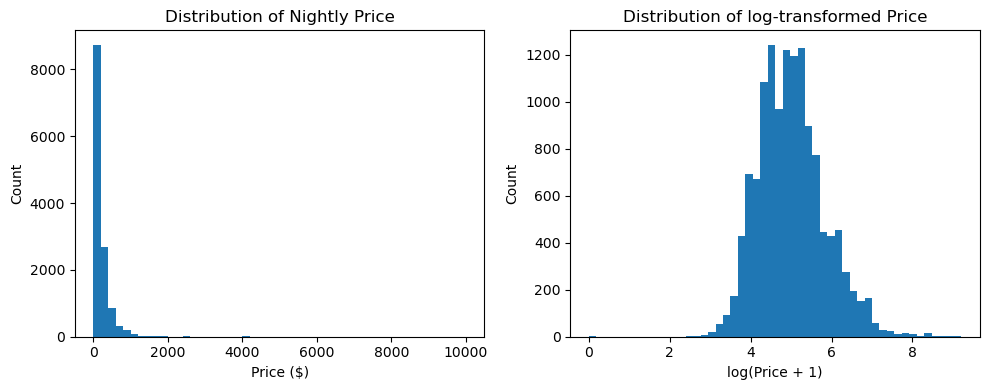

In [33]:
#This Figure will clearly show why the log transform is the correct way to go. It takes a heavily skewed feature and helps
# normalize it

plt.figure(figsize=(10, 4))

# Raw price
plt.subplot(1, 2, 1)
plt.hist(df["price"], bins=50)
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.title("Distribution of Nightly Price")

# Log-transformed price
plt.subplot(1, 2, 2)
plt.hist(df["log_price"], bins=50)
plt.xlabel("log(Price + 1)")
plt.ylabel("Count")
plt.title("Distribution of log-transformed Price")

plt.tight_layout()
plt.savefig("Histogram of Price vs Log Price.png")
plt.show()


### Relationship Between Capacity and Price
Analyzing the relationship between a property’s guest capacity (accommodates) and its nightly price reveals a positive trend: listings that accommodate more guests typically command higher prices. The log-transformed scatter plot helps linearize this trend, showing increased price levels as capacity grows. However, there is noticeable variability within each capacity level, indicating that capacity alone does not guarantee higher pricing. This suggests that additional features—such as location, amenities, and host identity factors—play important roles in price determination.

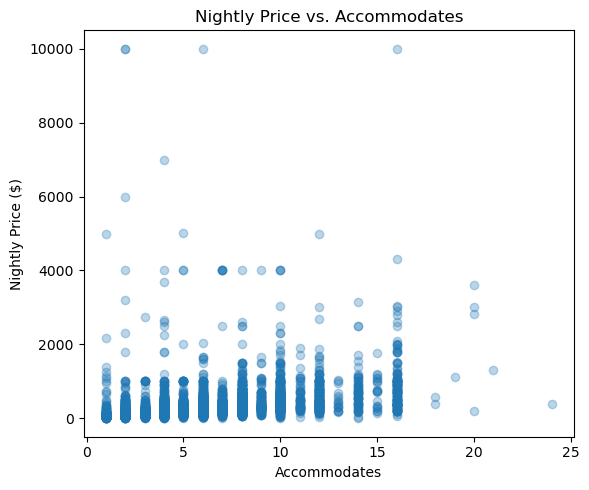

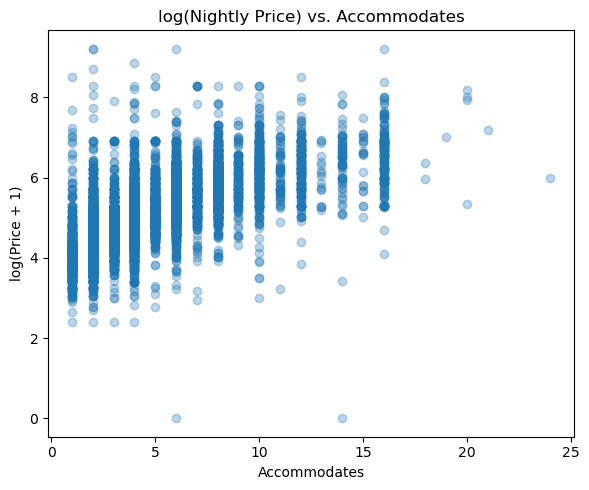

In [34]:
plt.figure(figsize=(6, 5))
plt.scatter(df["accommodates"], df["price"], alpha=0.3)
plt.xlabel("Accommodates")
plt.ylabel("Nightly Price ($)")
plt.title("Nightly Price vs. Accommodates")
plt.tight_layout()
plt.savefig("Log Nightly Price vs Accommodates.png")
plt.show()

plt.figure(figsize=(6, 5))
plt.scatter(df["accommodates"], df["log_price"], alpha=0.3)
plt.xlabel("Accommodates")
plt.ylabel("log(Price + 1)")
plt.title("log(Nightly Price) vs. Accommodates")
plt.tight_layout()
plt.savefig("Log Nightly Price vs Accommodates.png")
plt.show()



### Preprocessing and Feature Handling

### Missing Data Analysis
Only a subset of retained features contains missing values. The most impacted were security_deposit (~20%) and several review- and host-related variables (approximately 15–17%). Since these attributes contribute important pricing context, we chose not to exclude rows with missing information. Instead, we applied median imputation for numeric variables and most-frequent value imputation for categorical variables using a scikit-learn preprocessing pipeline. This approach helped preserve valuable data while preventing missingness from affecting model consistency.

In [4]:
# A quick glance at the number of Non null values in each of our columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13051 entries, 0 to 13050
Data columns (total 75 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                13051 non-null  int64  
 1   listing_url                       13051 non-null  object 
 2   name                              13051 non-null  object 
 3   summary                           12635 non-null  object 
 4   space                             10080 non-null  object 
 5   description                       12836 non-null  object 
 6   neighborhood_overview             9138 non-null   object 
 7   notes                             7103 non-null   object 
 8   transit                           8261 non-null   object 
 9   access                            8224 non-null   object 
 10  interaction                       8665 non-null   object 
 11  house_rules                       9587 non-null   object 
 12  thum

In [18]:
# A more comprehensive look into the number of missing values in each of our features, sorted by highest count for clarity.
# Identify and focus on the columns actually used in modeling (plus target)
cols_for_missing = feature_cols + ["price", "log_price"]
missing_counts = df[cols_for_missing].isna().sum()
missing_pct = missing_counts / len(df) * 100

missing_summary = (
    pd.DataFrame({
        "missing_count": missing_counts,
        "missing_pct": missing_pct
    })
    .sort_values("missing_pct", ascending=False)
)

missing_summary.head(20)  # show top 20 columns by missingness

,missing_count,missing_pct
security_deposit,2674,20.488851
review_scores_rating,2145,16.435522
host_response_time,2144,16.427860
host_response_rate,2144,16.427860
cleaning_fee,1504,11.524021
beds,9,0.068960
host_since,5,0.038311
host_has_profile_pic,5,0.038311
host_total_listings_count,5,0.038311
host_listings_count,5,0.038311


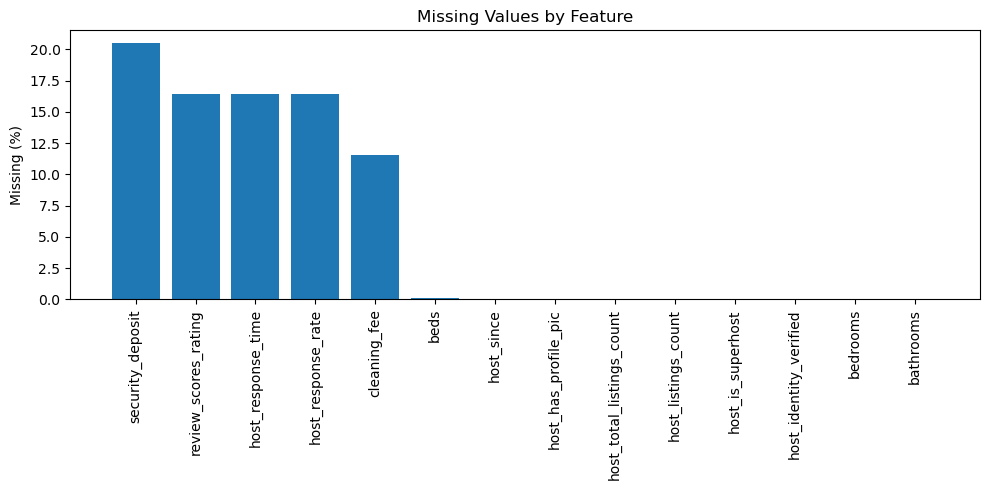

In [20]:
# Bar plot for columns with any missing data counts that are greater than 0
missing_nonzero = missing_summary[missing_summary["missing_count"] > 0]

plt.figure(figsize=(10, 5))
plt.bar(missing_nonzero.index, missing_nonzero["missing_pct"])
plt.xticks(rotation=90)
plt.ylabel("Missing (%)")
plt.title("Missing Values by Feature")
plt.tight_layout()

plt.savefig("Missing Values By Feature.png")
plt.show()


In [5]:


# ------------------------
# Helper cleaning functions
# ------------------------
def clean_currency(series):
    """Convert '$1,234.00' -> 1234.0, treat missing/empty as 0."""
    return (
        series.fillna("0")
              .astype(str)
              .str.replace(r"[\$,]", "", regex=True)
              .replace("", "0")
              .astype(float)
    )

def clean_bool(series):
    """Convert 't'/'f', 'True'/'False', True/False -> 1/0."""
    s = series.astype(str).str.lower()
    return s.isin(["t", "true", "1"]).astype(int)

def clean_percent(series):
    """Convert '95%' -> 0.95, handle NaN."""
    s = series.astype(str).str.strip()
    s = s.str.replace("%", "", regex=False)
    s = pd.to_numeric(s, errors="coerce") / 100.0
    return s.fillna(s.mean())

# ------------------------
# Clean target (price + log_price)
# ------------------------
df["price"] = clean_currency(df["nightly_price"])
df["log_price"] = np.log1p(df["price"])

# ------------------------
# Select features we keep
# ------------------------
feature_cols = [
    "neighbourhood_cleansed", "latitude", "longitude",
    "property_type", "room_type", "accommodates", "bathrooms",
    "bedrooms", "beds", "bed_type", "amenities",
    "host_since", "host_response_time", "host_response_rate",
    "host_is_superhost", "host_listings_count",
    "host_total_listings_count", "host_has_profile_pic",
    "host_identity_verified", "security_deposit",
    "cleaning_fee", "guests_included", "extra_people",
    "minimum_nights", "maximum_nights", "number_of_reviews",
    "number_of_stays", "review_scores_rating",
    "requires_license", "instant_bookable",
    "is_business_travel_ready", "cancellation_policy",
    "require_guest_profile_picture",
    "require_guest_phone_verification",
]

data = df[feature_cols].copy()

# ------------------------
# Feature engineering
# ------------------------

# Currency features
for col in ["security_deposit", "cleaning_fee", "extra_people"]:
    data[col] = clean_currency(data[col])

# Boolean-like features
bool_cols = [
    "host_is_superhost", "host_has_profile_pic", "host_identity_verified",
    "requires_license", "instant_bookable", "is_business_travel_ready",
    "require_guest_profile_picture", "require_guest_phone_verification",
]
for col in bool_cols:
    data[col] = clean_bool(data[col])

# Response rate
data["host_response_rate"] = clean_percent(data["host_response_rate"])

# Host tenure in years
ref_date = pd.to_datetime("2020-01-01")  # or use max(df["host_since"]) or similar
host_since_parsed = pd.to_datetime(df["host_since"], errors="coerce")
data["host_tenure_years"] = (ref_date - host_since_parsed).dt.days / 365.0
data["host_tenure_years"] = data["host_tenure_years"].fillna(
    data["host_tenure_years"].median()
)

# Review_scores_rating: simple imputation
data["review_scores_rating"] = pd.to_numeric(
    data["review_scores_rating"], errors="coerce"
)
data["review_scores_rating"] = data["review_scores_rating"].fillna(
    data["review_scores_rating"].mean()
)

# Number of amenities
def count_amenities(s):
    # s looks like: "{TV,Wifi,Kitchen,...}"
    s = str(s).strip()
    if s == "" or s == "nan":
        return 0
    # strip {} then split on comma
    s = s.strip("{}")
    if s == "":
        return 0
    return len([x for x in s.split(",") if x.strip() != ""])

data["num_amenities"] = data["amenities"].apply(count_amenities)

# We will drop raw 'amenities' string and 'host_since' in the model,
# keeping their engineered versions instead.
data = data.drop(columns=["amenities", "host_since"])

# ------------------------
# Train/validation split
# ------------------------
X = data
y = df["log_price"]  # our modeling target

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)


C:\Users\arvos\AppData\Local\Temp\ipykernel_31284\555208253.py:76: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  host_since_parsed = pd.to_datetime(df["host_since"], errors="coerce")


Train shape: (10440, 34)
Val shape: (2611, 34)


In [6]:
# Helper function for evaluation

def evaluate_on_price(y_true_log, y_pred_log, label="model"):
    """Compute MAE/RMSE in original dollar space, plus log-space RMSE."""
    # back-transform
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))

    print(f"=== {label} ===")
    print(f"MAE (dollars): {mae:,.2f}")
    print(f"RMSE (dollars): {rmse:,.2f}")
    print(f"RMSE (log_price): {rmse_log:.4f}")
    print()
    return {"mae": mae, "rmse": rmse, "rmse_log": rmse_log}


# Modeling

### Baseline 0: Predict using global mean of log price

In [7]:
# Baseline 0: always predict global mean log_price (from training set)
global_mean_log_price = y_train.mean()

y_pred_train_b0 = np.full_like(y_train, fill_value=global_mean_log_price)
y_pred_val_b0 = np.full_like(y_val, fill_value=global_mean_log_price)

metrics_b0_train = evaluate_on_price(y_train, y_pred_train_b0, label="Baseline 0 (train)")
metrics_b0_val   = evaluate_on_price(y_val, y_pred_val_b0, label="Baseline 0 (val)")


=== Baseline 0 (train) ===
MAE (dollars): 140.25
RMSE (dollars): 344.54
RMSE (log_price): 0.8267

=== Baseline 0 (val) ===
MAE (dollars): 143.23
RMSE (dollars): 387.04
RMSE (log_price): 0.8231



### Baseline 1: Predict using mean by neighborhood/room type

In [8]:
# Use neighbourhood_cleansed + room_type as a grouped baseline
group_cols = ["neighbourhood_cleansed", "room_type"]

# Use original X_train, not the encoded version
train_group = df.loc[X_train.index, group_cols].copy()
val_group   = df.loc[X_val.index,   group_cols].copy()

train_group["log_price"] = y_train.values

# Compute group means on training data
group_means = (
    train_group
    .groupby(group_cols)["log_price"]
    .mean()
    .reset_index()
)

# Merge group mean back to train/val using left joins
train_merge = train_group.merge(
    group_means, on=group_cols, how="left", suffixes=("", "_group_mean")
)
val_merge = val_group.merge(
    group_means, on=group_cols, how="left"
)

# If a group wasn't seen in training, fall back to global mean
train_pred_log = train_merge["log_price_group_mean"].fillna(global_mean_log_price)
val_pred_log   = val_merge["log_price"].fillna(global_mean_log_price)

metrics_b1_train = evaluate_on_price(y_train, train_pred_log, label="Baseline 1 (train)")
metrics_b1_val   = evaluate_on_price(y_val,   val_pred_log,   label="Baseline 1 (val)")


=== Baseline 1 (train) ===
MAE (dollars): 115.80
RMSE (dollars): 319.92
RMSE (log_price): 0.6182

=== Baseline 1 (val) ===
MAE (dollars): 121.38
RMSE (dollars): 368.98
RMSE (log_price): 0.6383



### One hot encode categoricals and scale numerics (ML Prep)

In [9]:
# ------------------------
# 7. ColumnTransformer for ML models (with imputation)
# ------------------------

numeric_features = [
    "latitude", "longitude",
    "accommodates", "bathrooms", "bedrooms", "beds",
    "host_response_rate", "host_listings_count", "host_total_listings_count",
    "security_deposit", "cleaning_fee", "guests_included", "extra_people",
    "minimum_nights", "maximum_nights", "number_of_reviews",
    "number_of_stays", "review_scores_rating",
    "host_tenure_years", "num_amenities",
] + bool_cols  # your bool_cols list from earlier

categorical_features = [
    "neighbourhood_cleansed",
    "property_type",
    "room_type",
    "bed_type",
    "host_response_time",
    "cancellation_policy",
]

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
)


### Model 1: Ridge Regression (Linear)

In [10]:
X_train.isna().sum().sort_values(ascending=False).head(20)


host_response_time                  1724
beds                                   6
host_total_listings_count              5
host_listings_count                    5
bathrooms                              2
bedrooms                               2
requires_license                       0
maximum_nights                         0
number_of_reviews                      0
number_of_stays                        0
review_scores_rating                   0
neighbourhood_cleansed                 0
instant_bookable                       0
extra_people                           0
is_business_travel_ready               0
cancellation_policy                    0
require_guest_profile_picture          0
require_guest_phone_verification       0
host_tenure_years                      0
minimum_nights                         0
dtype: int64

In [11]:
ridge_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", Ridge(alpha=1.0, random_state=42))
    ]
)

ridge_model.fit(X_train, y_train)
y_pred_train_ridge = ridge_model.predict(X_train)
y_pred_val_ridge   = ridge_model.predict(X_val)

metrics_ridge_train = evaluate_on_price(y_train, y_pred_train_ridge, label="Ridge (train)")
metrics_ridge_val   = evaluate_on_price(y_val,   y_pred_val_ridge,   label="Ridge (val)")


=== Ridge (train) ===
MAE (dollars): 84.16
RMSE (dollars): 287.83
RMSE (log_price): 0.4664

=== Ridge (val) ===
MAE (dollars): 89.09
RMSE (dollars): 345.69
RMSE (log_price): 0.4806



### Model 2: Random Forest

In [12]:
# Orignal Random forest model showed clear signs of overfitting. To combat this,
# a max depth of 15 (preiviously none) was implemented and the min samples per leaf was 
# increased to 10

rf_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestRegressor(
            n_estimators=200,
            max_depth=15,          # limit depth
            min_samples_leaf=10,   # require more samples in leaves
            random_state=42,
            n_jobs=-1,
        )),
    ]
)


rf_model.fit(X_train, y_train)
y_pred_train_rf = rf_model.predict(X_train)
y_pred_val_rf   = rf_model.predict(X_val)

metrics_rf_train = evaluate_on_price(y_train, y_pred_train_rf, label="Random Forest (train)")
metrics_rf_val   = evaluate_on_price(y_val,   y_pred_val_rf,   label="Random Forest (val)")


=== Random Forest (train) ===
MAE (dollars): 62.42
RMSE (dollars): 252.51
RMSE (log_price): 0.3490

=== Random Forest (val) ===
MAE (dollars): 80.33
RMSE (dollars): 331.58
RMSE (log_price): 0.4399



### Model 2: Hyperparameters tuned (randomized search)


In [15]:
from sklearn.model_selection import RandomizedSearchCV

rf_base = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestRegressor(
            n_estimators=200,
            random_state=42,
            n_jobs=-1,
        )),
    ]
)

param_dist = {
    "model__max_depth": [10, 15, 20, None],
    "model__min_samples_leaf": [1, 5, 10, 20],
    "model__max_features": ["sqrt", "log2", 0.5],
}

rf_search = RandomizedSearchCV(
    rf_base,
    param_distributions=param_dist,
    n_iter=10,
    scoring="neg_mean_absolute_error",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1,
)

rf_search.fit(X_train, y_train)
best_rf_model = rf_search.best_estimator_

y_pred_train_rf_best = best_rf_model.predict(X_train)
y_pred_val_rf_best   = best_rf_model.predict(X_val)

metrics_rf_best_train = evaluate_on_price(y_train, y_pred_train_rf_best, label="RF tuned (train)")
metrics_rf_best_val   = evaluate_on_price(y_val,   y_pred_val_rf_best,   label="RF tuned (val)")

print("Best params:", rf_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
=== RF tuned (train) ===
MAE (dollars): 39.99
RMSE (dollars): 168.69
RMSE (log_price): 0.2168

=== RF tuned (val) ===
MAE (dollars): 77.01
RMSE (dollars): 322.78
RMSE (log_price): 0.4326

Best params: {'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 20}


# Evaluation

## Section: Feature Importance and Interpretation

To better understand how our models arrive at their price predictions, we extracted feature importance scores (Gini importances) from both the initial Random Forest and the tuned Random Forest. In both models, a consistent pattern emerges: capacity, property type, cleaning/fee structure, and location are the key drivers of nightly price.

Across both versions of the model, the most important features include the number of bedrooms (num__bedrooms), the number of guests the listing can accommodate (num__accommodates), whether the listing is an entire home/apartment (cat__room_type_Entire home/apt), the number of bathrooms (num__bathrooms), and geographic coordinates (num__longitude and num__latitude). Cleaning-related fields such as num__cleaning_fee and demand or reputation indicators such as num__number_of_reviews and num__number_of_stays also appear among the top contributors in both models. The fact that these variables remain highly important before and after tuning suggests that the model has a stable view of what fundamentally drives Airbnb pricing: larger properties that can host more guests, are entire homes, include cleaning fees, and are located in particular areas tend to command higher prices, especially when they have accumulated more stays and reviews.

Tuning the Random Forest slightly changes the relative importance of features and introduces a few additional signals into the top 15. In the original model, num__bedrooms dominated the importance ranking, accounting for a very large share of total importance, while several constraints and host-related variables (e.g., num__minimum_nights, num__maximum_nights, num__host_tenure_years, num__num_amenities, and num__extra_people) also appeared. After tuning, importance is more evenly distributed: capacity features (num__accommodates, num__bedrooms, num__beds) remain crucial, but we also see higher importance for pricing and booking parameters such as num__guests_included, num__security_deposit, and the presence of different room types (cat__room_type_Private room). Host activity measures (num__host_total_listings_count, num__host_listings_count) become more prominent as well. This shift suggests that, once the model is better regularized and its hyperparameters adjusted, it relies less on a single dominant predictor and more on a combination of capacity, pricing rules, and host experience.

Overall, the agreement between the two Random Forests on the core set of important features gives us confidence that the model is learning meaningful structure from the data rather than artifacts of a particular configuration. At the same time, the tuned model’s more balanced importance distribution indicates that pricing decisions are multifaceted: nightly price is not determined solely by one factor such as bedrooms, but by an interaction between property size, room type, location, cleaning and security fees, and host behavior.

### Helper Function to discover feature importance (gini index)

In [ ]:
def get_feature_importances_from_pipeline(pipeline, feature_names):
    """
    Extract feature importances from a pipeline that contains:
      ("preprocess", preprocessor)
      ("model", RandomForestRegressor)    
    """
    # Step 1: Get the preprocessor and model
    preprocessor = pipeline.named_steps["preprocess"]
    model = pipeline.named_steps["model"]
    
    # Step 2: Get transformed feature names
    # This will only work if you set:
    #   set_config(transform_output="pandas") earlier.
    # or you can use get_feature_names_out below.
    try:
        transformed_features = preprocessor.get_feature_names_out(feature_names)
    except AttributeError:
        # If using older sklearn:
        transformed_features = []
        for name, transformer, cols in preprocessor.transformers_:
            if name == "num":
                transformed_features.extend(cols)
            elif name == "cat":
                # Handle one-hot expanded features
                oh = transformer.named_steps.get("onehot", None)
                if oh:
                    cat_names = oh.get_feature_names_out(cols)
                    transformed_features.extend(cat_names)
    
    # Step 3: Extract importances
    importances = model.feature_importances_
    
    fi = pd.DataFrame({
        "feature": transformed_features,
        "importance": importances
    }).sort_values("importance", ascending=False)
    
    return fi

### Random Forest Gini Index

In [35]:
# Use the gini index to see which features contributed the most to the models performance
feature_importance_df = get_feature_importances_from_pipeline(rf_model, X_train.columns)
feature_importance_df.head(20)  # top 20 features


,feature,importance
4,num__bedrooms,0.369880
2,num__accommodates,0.139779
167,cat__room_type_Entire home/apt,0.099056
3,num__bathrooms,0.084187
1,num__longitude,0.068779
10,num__cleaning_fee,0.063159
0,num__latitude,0.025361
15,num__number_of_reviews,0.019726
16,num__number_of_stays,0.019545
13,num__minimum_nights,0.016020


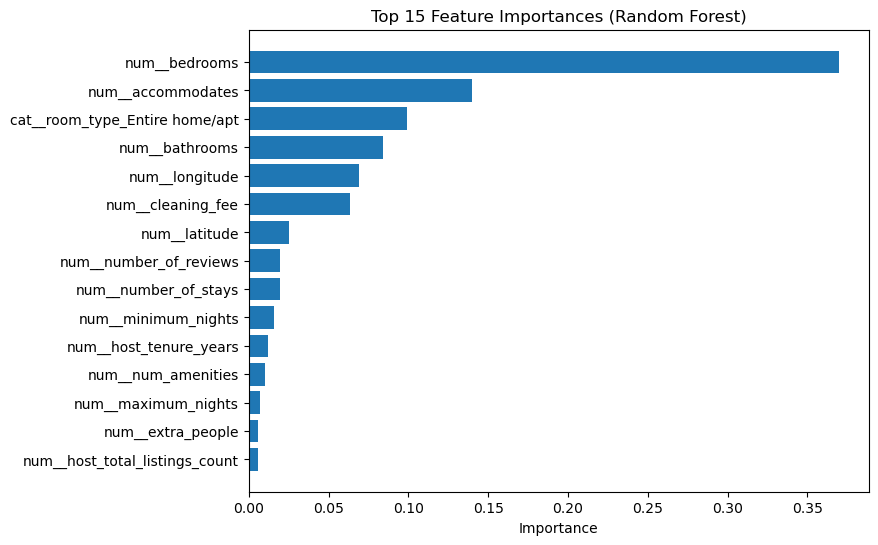

In [37]:
# Visualize the most important features
top_n = 15
plt.figure(figsize=(8, 6))
plt.barh(feature_importance_df["feature"].head(top_n)[::-1],
         feature_importance_df["importance"].head(top_n)[::-1])
plt.title(f"Top {top_n} Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()

### Tuned Random Forest Gini Index

In [16]:
# Use the gini index to see which features contributed the most to the  tuned RF model's performance

tuned_feature_importance_df = get_feature_importances_from_pipeline(best_rf_model, X_train.columns)
tuned_feature_importance_df.head(20)

,feature,importance
2,num__accommodates,0.105382
4,num__bedrooms,0.105103
10,num__cleaning_fee,0.086324
3,num__bathrooms,0.071075
167,cat__room_type_Entire home/apt,0.057416
5,num__beds,0.057090
1,num__longitude,0.055871
168,cat__room_type_Private room,0.046056
11,num__guests_included,0.031531
0,num__latitude,0.026631


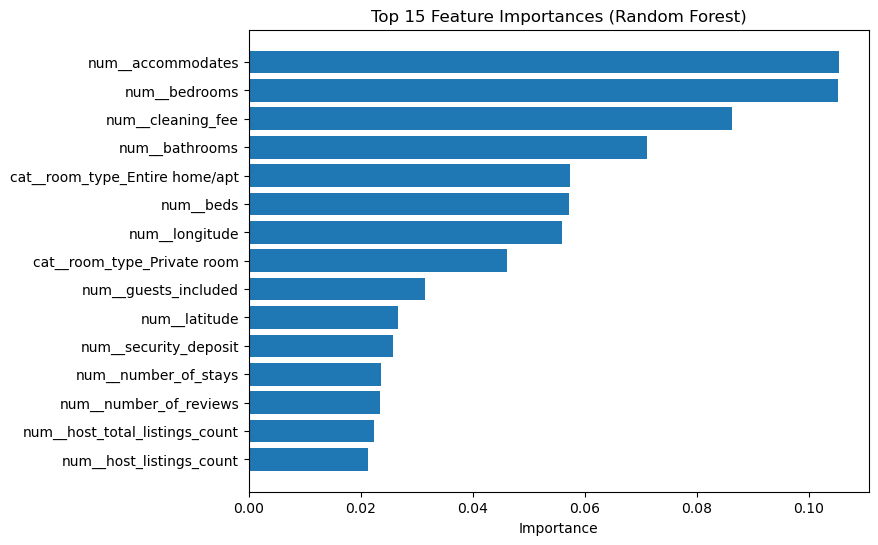

In [17]:
# Visualize Feature Importance to gain a better understanding of each features contribution to the model's performance
top_n = 15
plt.figure(figsize=(8, 6))
plt.barh(tuned_feature_importance_df["feature"].head(top_n)[::-1],
         tuned_feature_importance_df["importance"].head(top_n)[::-1])
plt.title(f"Top {top_n} Feature Importances (Tuned Random Forest)")
plt.xlabel("Importance")
plt.show()

### Predicted vs Actual Price Performance
The scatter plot comparing predicted versus actual nightly prices on the validation set shows that the tuned Random Forest model closely approximates price for a large majority of listings. Most predictions cluster tightly around the diagonal reference line, demonstrating strong model accuracy across common price ranges. However, high-value listings exhibit larger deviations, generally falling below the diagonal. This suggests a tendency to underpredict exceptionally expensive properties, likely due to their limited representation and greater variability in the dataset.

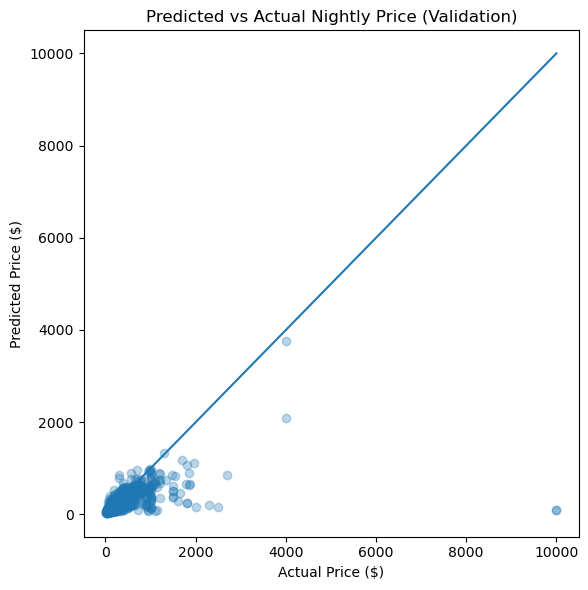

In [30]:
# Get predictions in log space and convert back to dollars
y_val_pred_log = best_rf_model.predict(X_val)
y_val_true_log = y_val  # already log_price

y_val_true = np.expm1(y_val_true_log)
y_val_pred = np.expm1(y_val_pred_log)

# Scatter plot: predicted vs actual
plt.figure(figsize=(6, 6))
plt.scatter(y_val_true, y_val_pred, alpha=0.3)
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Predicted vs Actual Nightly Price (Validation)")

# Diagonal reference line
min_price = min(y_val_true.min(), y_val_pred.min())
max_price = max(y_val_true.max(), y_val_pred.max())
plt.plot([min_price, max_price], [min_price, max_price])

plt.tight_layout()
plt.savefig("Predicted vs Actual Nightly Price (Validation).png")
plt.show()


### Residual Analysis
Residuals are centered around zero for most predictions, indicating minimal systematic bias in the model. However, there is a visible increase in residual spread for higher predicted values, demonstrating heteroskedasticity—larger absolute errors occur more frequently among premium listings. Such behavior is common in pricing models, as expensive properties tend to vary substantially based on unobserved or non-structured factors (e.g., design quality, view, luxury finishes). Despite these variations, overall residuals remain well-controlled, supporting the model's effectiveness across typical price levels.

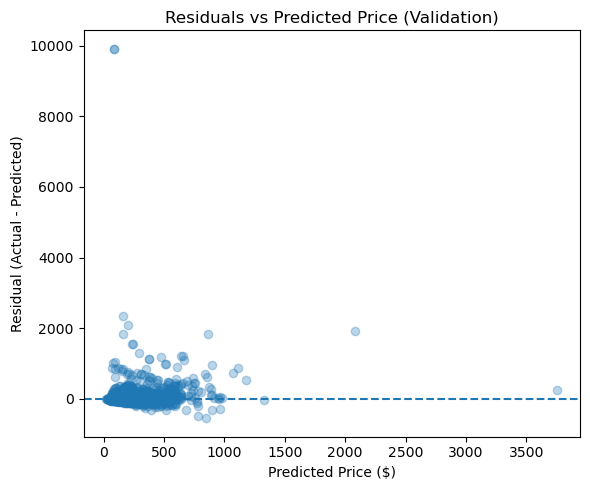

In [31]:
residuals = y_val_true - y_val_pred

plt.figure(figsize=(6, 5))
plt.scatter(y_val_pred, residuals, alpha=0.3)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted Price ($)")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted Price (Validation)")
plt.tight_layout()
plt.savefig("Residuals vs Predicted Price (Validation).png")
plt.show()
